<a href="https://colab.research.google.com/github/shashanknigade/Data-Science/blob/main/NLP/News_Aggregator_Spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# News Clustering
---
### Problem Statement
Develop algorithm technique to group news articles by story.
**Dataset**:
https://www.kaggle.com/uciml/news-aggregator-dataset

---

### Approach
1.   Text Preprocessing using Spacy & NLTK Package
1.   TF-IDF generation
1.   Dimensionality reduction
1.   Unsupervised clustering
1.   Metrics calculation







## Dependency Installation and data preparation

In [ ]:
!pip install umap-learn
!pip install hdbscan
!pip install textacy

In [ ]:
# Import all necessary libraries
# For file copy from Kaggle etc.
import os, shutil
from google.colab import drive
import zipfile
# For data exploration and graphs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# For text preprocessing
import gensim
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
from gensim.parsing.preprocessing import strip_punctuation
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk.tokenize import word_tokenize
# For saving models etc
import pickle
# Deep Neural Network libraries
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
# KMeans
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.cluster import DBSCAN
nltk.download('punkt')
import hdbscan
import umap
import spacy
import textacy

In [3]:
# Mount the drive to read kaggle config file
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
# global config values
zipName = 'news-aggregator-dataset.zip'
csvFileName = 'uci-news-aggregator.csv'
modelFileSaveLocation = '/content/gdrive/MyDrive'
run = 'newsagg-2'
exportModels = True

In [5]:
# Create kaggle folder
os.makedirs('data',exist_ok=True)
os.makedirs('data/kaggle',exist_ok=True)
# Change the current working directory to data where we will download 
# the data
os.chdir(os.path.join(os.getcwd(),'data'))

In [6]:
# copy kaggle.json to the content folder's kaggle folder
shutil.copy('/content/gdrive/MyDrive/kaggle/kaggle.json',
            'kaggle')
# Set environment for kaggle directory to the folder in prev. step
os.environ['KAGGLE_CONFIG_DIR'] = 'kaggle'

In [7]:
# download the dataset
!kaggle datasets download -d uciml/news-aggregator-dataset
zipfileref = zipfile.ZipFile(zipName,'r')
# Extract the files in pwd
zipfileref.extractall()

 32% 9.00M/28.0M [00:00<00:00, 40.2MB/s]
100% 28.0M/28.0M [00:00<00:00, 80.6MB/s]


In [8]:
# Read the csv file
df = pd.read_csv(csvFileName)

In [ ]:
# Below code was used to resolve error received while using Spacy
# OSError: [E053] Could not read config.cfg from /usr/local/lib/python3.7/dist-packages/en_core_web_sm/en_core_web_sm-2.2.5/config.cfg
#!pip install -U pip setuptools wheel
#!pip install -U spacy
#!python -m spacy download en_core_web_sm

## Approach 1 - Explanation

This approach is based on below observation 
*   Generally news headlines contain Named Entities like company name, country, person name etc and nouns. These 2 characteristics can be used to find similar news articles.

 

In [13]:
nlp = spacy.load('en_core_web_sm')

In [14]:
def ProcessTest(text):
  '''
    text: Input Text
    This function removes stop words from a text, removes punctuation
    and lowers the case
  '''
  text = remove_stopwords(text)
  text = strip_punctuation(text)
  return str.lower(str.strip(text))

In [17]:
def ShowNENouns(text):
  '''
    text: Input Text
    This function extracts Nouns and Entities
  '''
  sObj = nlp(text)
  processed = []
  for n in sObj.noun_chunks:
    processed.append(n.text)

  for e in sObj.ents:
    processed.append(e.text)
  return processed
  

In [18]:
#try it out
ShowNENouns(df.iloc[1,:]['TITLE'])

["Fed's Charles Plosser",
 'high bar',
 'change',
 'pace',
 'Fed',
 'Charles Plosser']

### Trial run on 1000 news

In [19]:
# Lets test on first 1000 entries
df_1000 = df.iloc[:1000,:].copy()

The clustering will be done based on the headline of the news which is stored in TITLE column of the dataframe

In [20]:
# Store the Named Entities and Nouns for each news in this list
inputText = []
for txt in df_1000['TITLE']:
  inputText.append(ShowNENouns(txt))

In [23]:
# Read one entry to check for extracted Entities and Nouns
inputText[0]

['Fed official', 'weak data', 'weather', 'taper', 'Fed']

In [36]:
# Use TF-IDF to extract features
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X_tf_1000 = vectorizer.fit_transform([' '.join(a,) for a in inputText])

In [37]:
X_tf_1000.shape

(1000, 1320)

In [28]:
# Lets convert story column in dataframe to lables using Ordinal Encoding 
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
df_1000["STORY_CODE"] = ord_enc.fit_transform(df_1000[["STORY"]])

In [38]:
df_1000[['STORY','STORY_CODE']]

,STORY,STORY_CODE
0,ddUyU0VZz0BRneMioxUPQVP6sIxvM,11.0
1,ddUyU0VZz0BRneMioxUPQVP6sIxvM,11.0
2,ddUyU0VZz0BRneMioxUPQVP6sIxvM,11.0
3,ddUyU0VZz0BRneMioxUPQVP6sIxvM,11.0
4,ddUyU0VZz0BRneMioxUPQVP6sIxvM,11.0
...,...,...
995,dw0Jnfj8vEPaLZM8TQMSCbVaYeyrM,15.0
996,dw0Jnfj8vEPaLZM8TQMSCbVaYeyrM,15.0
997,dw0Jnfj8vEPaLZM8TQMSCbVaYeyrM,15.0
998,dw0Jnfj8vEPaLZM8TQMSCbVaYeyrM,15.0


In [41]:
df_1000['STORY_CODE'].value_counts()

2.0     129
12.0    127
0.0     123
17.0    112
10.0     61
7.0      60
15.0     56
9.0      54
6.0      53
8.0      37
13.0     33
1.0      32
16.0     31
5.0      28
4.0      25
14.0     21
3.0       9
11.0      9
Name: STORY_CODE, dtype: int64

' As you can see in the output, the dimentionality reduction does not capture the \n    proper clusters even in the labled data. NOTE - We are doing this step just for \n    doing a check, in real world we would not have a lables for news items already available\n    with us.\n\n    Still there are few well defined clusters\n'

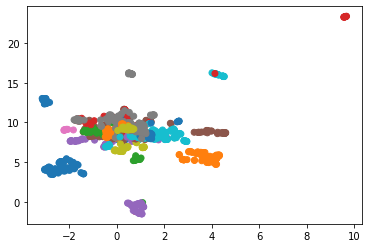

In [52]:
# Lets use UMAP to plot the vector for visualization purpose
reducer = umap.UMAP()
# Reducer will reduce the dimentionality to 2 so that it can be plotted
# *** It is important to note that data loss can happen during the dimentionality reduction
# and this visualazation may not be useful as we scale our solution
embedding_original = reducer.fit_transform(X_tf_1000)
# Plot all rows and column 0 as x and all rows and column 1 as y from embedding
plt.scatter(embedding_original[:,0],embedding_original[:,1],c=df_1000.iloc[:,:]['STORY_CODE'],cmap='tab10')

''' As you can see in the output, the dimentionality reduction does not capture the 
    proper clusters even in the labled data. NOTE - We are doing this step just for 
    doing a check, in real world we would not have a lables for news items already available
    with us.

    Still there are few well defined clusters
'''

#### KMeans Clustering
Lets start with a random number of clusters and then we will find the optimum clusters. We will explore cluster number finding later in this notebook

In [43]:
Kmean = KMeans(n_clusters=15)
Kmean.fit(X_tf_1000)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [44]:
df_1000['Predicted_kmans'] = Kmean.labels_

1.   Lets compare the available story lables with the predicted kmeans class lables.
2.   These will not exactly match for value as KMeans will come up with its owne labels. E.g. the data may have a story label as 10 but KMeans may have a label 9 assigned to denote this predicted class.
3. Hence we will just see if actual labes have only one type of predicted lable or not
4. To check this we will see entries which has predicted label as 2

In [47]:
df_1000[df_1000['Predicted_kmans'] == 2][['TITLE','STORY_CODE']]

,TITLE,STORY_CODE
47,"EBay, Icahn talk smack",16.0
50,Carl Icahn Rift Hurts eBay (EBAY),16.0
51,EBay rejects Icahn slate of directors,16.0
52,CARL ICAHN: eBay Shareholders Lost $4 Billion ...,16.0
53,Ebay to Shareholders: Vote Against Icahn Nominees,16.0
54,"EBay rejects Icahn board nominees, asks invest...",16.0
55,Icahn Targets Ebay Chief Donahoe After Company...,16.0
56,TECH STOCKS: EBay And Icahn Keep Trading Punches,16.0
57,EBay asks shareholders to vote against Carl Ic...,16.0
58,EBay asks shareholders to vote against Icahn b...,16.0


At least the predicted lable with value 2 looks promising as there are only 2 news which had different original lables. And those has some similar keywords like eBay. Hence I would say not very bad

In [53]:
embedding_predicted = reducer.fit_transform(X_tf_1000)
embedding_predicted.shape

(1000, 2)

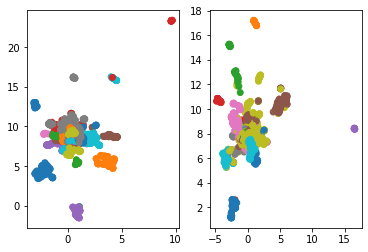

In [54]:
fig,ax = plt.subplots(nrows=1,ncols=2)
ax[0].scatter(embedding_original[:,0],embedding_original[:,1],c=df_1000.iloc[:,:]['STORY_CODE'],cmap='tab10')
ax[1].scatter(embedding_predicted[:,0],embedding_predicted[:,1],c=df_1000['Predicted_kmans'],cmap='tab10')

In [65]:
# Lets now group the news entries based on predicted lables and see
# how may of them have different original labels
groups = df_1000.groupby('Predicted_kmans')
df_1000_eval = pd.DataFrame(columns=['Predict_Class','Accuracy','Total_Classes'])
ind = 0
for name,group in groups:
  total = len(group)
  data = group['STORY_CODE'].value_counts()
  max = data.iloc[0]
  df_1000_eval.loc[ind] = [name,max/total,len(data)]
  ind += 1

df_1000_eval

,Predict_Class,Accuracy,Total_Classes
0,0.0,0.982143,2.0
1,1.0,0.545455,4.0
2,2.0,0.931034,3.0
3,3.0,0.961538,2.0
4,4.0,1.000000,1.0
5,5.0,1.000000,1.0
6,6.0,0.866667,2.0
7,7.0,1.000000,1.0
8,8.0,0.676471,5.0
9,9.0,0.934066,4.0


In [67]:
df_1000_eval['Accuracy'].mean()

0.8794116049963958